### **Lab7.ipynb**

#### Activity
- Data science - Laboratorio 7

#### Authors: 
- Diego Lemus
- Fabián Juárez


#### Date:
- 22 de Septiembre 2024


#### Repository:
- Link: https://github.com/FabianJuarez182/DS-LAB7.git

### Task 2 y 3

In [1]:
import json
import pandas as pd
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Descargar las stopwords en español de nltk
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

# Cargar el archivo .txt con manejo de errores para JSON
def load_json_txt(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-16') as file:  # Cambiamos a utf-16
        for line in file:
            line = line.strip()  # Eliminar espacios en blanco y saltos de línea
            if line:  # Verificar que la línea no esté vacía
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError:
                    continue  # Ignorar líneas mal formadas
    return pd.DataFrame(data)

# Función para limpiar el texto
def clean_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Eliminar caracteres especiales, menciones y números
    text = re.sub(r'\@\w+|\#|\d+', '', text)
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Eliminar stopwords en español
    text = ' '.join([word for word in text.split() if word not in spanish_stopwords])
    return text

# Cargar el archivo de texto
df = load_json_txt('tioberny.txt')

# Aplicar la función de limpieza a la columna de texto
df['cleaned_text'] = df['rawContent'].apply(clean_text)

# Visualizar los datos limpiados
print(df[['rawContent', 'cleaned_text']].head())

# Calcular la frecuencia de las palabras
word_freq = Counter(" ".join(df['cleaned_text']).split())

# Mostrar las palabras más frecuentes después de la limpieza
print(word_freq.most_common(10))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\domot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                          rawContent  \
0  _\nConfirmado Compañeres,\n\nEl impuesto por l...   
1  #URGENTE Lo que los medios #faferos no informa...   
2  @IvanDuque @BArevalodeLeon Con que usaste PEGA...   
3  @IvanDuque @BArevalodeLeon Entre Ellos se enti...   
4  El presidente @BArevalodeLeon y la vicepreside...   

                                        cleaned_text  
0  confirmado compañeres impuesto —solo cuenta pa...  
1  urgente medios faferos informaron ayer acerca ...  
2  usaste pegasus espiar detractores obra narcisi...  
3         entienden bien cuadrando productivareunión  
4  presidente vicepresidenta participan sesión so...  
[('si', 462), ('presidente', 430), ('gobierno', 334), ('solo', 287), ('guatemala', 245), ('vos', 197), ('ser', 185), ('q', 181), ('corruptos', 177), ('bien', 171)]


In [2]:
import networkx as nx

# Función ajustada para extraer respuestas, menciones y retweets
def extract_interactions(row):
    interactions = []
    
    # Validar que 'user' y 'username' existan y sean cadenas
    if 'user' in row and isinstance(row['user'], dict) and 'username' in row['user']:
        user = row['user']['username'].lower() if isinstance(row['user']['username'], str) else None
    else:
        user = None

    # Extraer respuestas (si existen y son válidas)
    if 'inReplyToUser' in row and isinstance(row['inReplyToUser'], dict):
        replied_to_user = row['inReplyToUser'].get('username', None)
        if user and replied_to_user:
            interactions.append(('reply', user, replied_to_user.lower()))
    
    # Extraer menciones (si existen y son válidas)
    if 'mentionedUsers' in row and isinstance(row['mentionedUsers'], list):
        for mention in row['mentionedUsers']:
            if 'username' in mention and isinstance(mention['username'], str):
                interactions.append(('mention', user, mention['username'].lower()))
    
    # Extraer retweets (si existen y son válidos)
    if 'retweetedTweet' in row and isinstance(row['retweetedTweet'], dict):
        retweeted_user = row['retweetedTweet'].get('user', {}).get('username')
        if user and retweeted_user:
            interactions.append(('retweet', user, retweeted_user.lower()))
    
    return interactions

# Aplicar la extracción de interacciones a cada tweet
df['interactions'] = df.apply(extract_interactions, axis=1)

# Descomponer las interacciones en un DataFrame
interactions = []
for interaction_list in df['interactions']:
    interactions.extend(interaction_list)

# Crear un DataFrame con las interacciones
interaction_df = pd.DataFrame(interactions, columns=['type', 'source', 'target'])

# Eliminar duplicados
interaction_df = interaction_df.drop_duplicates()

# Contar el número de menciones, respuestas y retweets
interaction_counts = interaction_df['type'].value_counts()

# Mostrar cuántas interacciones de cada tipo existen
print("Conteo de interacciones por tipo:")
print(interaction_counts)

# Función para crear y exportar un grafo para cada tipo de interacción
def create_and_export_graph(interaction_type, interaction_df):
    # Filtrar las interacciones por el tipo deseado (mención, respuesta o retweet)
    filtered_df = interaction_df[interaction_df['type'] == interaction_type]
    
    # Verificar si hay interacciones para este tipo
    if filtered_df.empty:
        print(f"No se encontraron interacciones de tipo {interaction_type}")
        return
    
    # Crear un grafo dirigido
    G = nx.DiGraph()
    
    # Añadir las interacciones filtradas al grafo
    for index, row in filtered_df.iterrows():
        G.add_edge(row['source'], row['target'], interaction_type=row['type'])
    
    # Exportar el grafo a Gephi en formato GEXF
    file_name = f"user_interactions_graph_{interaction_type}.gexf"
    nx.write_gexf(G, file_name)
    print(f"Grafo de {interaction_type} exportado a Gephi como '{file_name}'")

# Crear y exportar grafos para menciones, respuestas y retweets
create_and_export_graph('mention', interaction_df)
create_and_export_graph('reply', interaction_df)
create_and_export_graph('retweet', interaction_df)

Conteo de interacciones por tipo:
type
mention    12246
reply       3872
Name: count, dtype: int64
Grafo de mention exportado a Gephi como 'user_interactions_graph_mention.gexf'
Grafo de reply exportado a Gephi como 'user_interactions_graph_reply.gexf'
No se encontraron interacciones de tipo retweet


Se evidencia que no existen los retweet de manera explicita por lo que se utilizará la cnatidad de retweets de cada tweet para visualizar que tanto auge tienen y que tan influyente es el usuario.

### Task 4

Número total de tweets: 5019
Número de usuarios únicos: 2620
Número total de menciones: 12246
Número total de respuestas: 3872
Hashtags más frecuentes:
URGENTE: 25
GuatemalaSaleAdelante: 24
MinfinSaleAdelante: 17
Guatemala: 15
Presupuesto2025: 14
UnPresupuestoParaLaPoblación: 13
EnElPaísDCA: 12
NacionalesAGN: 8
XelaNews: 7
ElEstor: 7


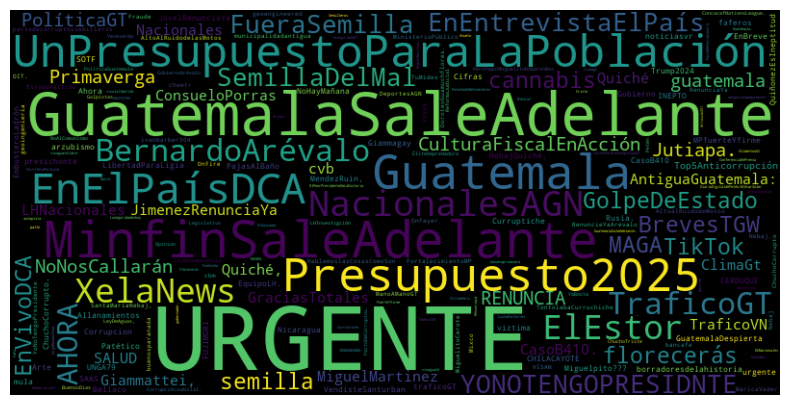

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Número total de tweets
num_tweets = len(df)
print(f"Número total de tweets: {num_tweets}")

# Número de usuarios únicos (quién escribió el tweet)
unique_users = df['user'].apply(lambda x: x['username'].lower() if isinstance(x, dict) else None).nunique()
print(f"Número de usuarios únicos: {unique_users}")

# Número total de menciones
total_mentions = interaction_df[interaction_df['type'] == 'mention'].shape[0]
print(f"Número total de menciones: {total_mentions}")

# Número total de respuestas
total_replies = interaction_df[interaction_df['type'] == 'reply'].shape[0]
print(f"Número total de respuestas: {total_replies}")

# Extraer hashtags de los tweets (si existen)
def extract_hashtags(text):
    return [part[1:] for part in text.split() if part.startswith('#')]

df['hashtags'] = df['rawContent'].apply(lambda x: extract_hashtags(x) if isinstance(x, str) else [])

# Contar hashtags más frecuentes
all_hashtags = [hashtag for hashtags in df['hashtags'] for hashtag in hashtags]
hashtag_counts = Counter(all_hashtags)
top_hashtags = hashtag_counts.most_common(10)

print("Hashtags más frecuentes:")
for hashtag, count in top_hashtags:
    print(f"{hashtag}: {count}")

# Nube de palabras para hashtags
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(hashtag_counts)

# Visualizar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Preguntas Interesantes

#### ¿Cuáles son los usuarios más mencionados?

In [4]:
mention_counts = interaction_df[interaction_df['type'] == 'mention']['target'].value_counts().head(10)
print("Usuarios más mencionados:")
print(mention_counts)


Usuarios más mencionados:
target
barevalodeleon    2523
guatemalagob       613
ubaldomacu         407
santipalomov       370
mpguatemala        335
fjimenezmingob     278
congresoguate      218
__vadertg          214
mingobguate        208
usaidguate         187
Name: count, dtype: int64


El conjunto de datos muestra que el usuario barevalodeleon es, por un amplio margen, el más mencionado, acumulando un total de 2,523 menciones. Esto indica que este usuario está en el centro de muchas conversaciones y recalca que es una figura de gran relevancia en los temas que se discuten dentro de esta red. Su número de menciones supera significativamente al del resto de usuarios, lo que sugiere que las discusiones a su alrededor son recurrentes y altamente visibles.

Otros usuarios destacados incluyen a guatemalagob, con 613 menciones, lo que refleja el importante rol que juega esta entidad gubernamental en las discusiones. La presencia del gobierno es claramente significativa en los diálogos, ya que este usuario es el segundo más mencionado. A continuación, ubaldomacu con 407 menciones y santipalomov con 370 menciones son también usuarios influyentes en las interacciones.

Además, usuarios como mpguatemala y fjimenezmingob, con 335 y 278 menciones respectivamente, refuerzan la idea de que figuras públicas y entidades relacionadas con el gobierno son actores clave en estas conversaciones. Este patrón se mantiene con otros usuarios en el ranking, como congresoguate y __vadertg, lo que sugiere que las menciones están vinculadas a temas de relevancia nacional, principalmente centrados en asuntos gubernamentales y sociales.

Esto refleja un interés predominante en figuras públicas, instituciones gubernamentales y temas relacionados con el manejo del país en las conversaciones analizadas.

### ¿Cuáles son los temas más discutidos (hashtags) por los usuarios que generan la mayor cantidad de respuestas?

Usuarios con más respuestas:
target
barevalodeleon     612
ubaldomacu         368
guatemalagob       169
__vadertg          159
olsenpsico         152
fjimenezmingob     146
elquenews          139
vicentecarrera_    121
ivanduque          111
mendiamariela       75
Name: count, dtype: int64
Número de tweets con usuarios que generan respuestas: 90
Hashtags más discutidos por los usuarios que generan más respuestas:
URGENTE: 12
TraficoGT: 6
Guatemala: 6
EnEntrevistaElPaís: 4
GuatemalaSaleAdelante: 3
TraficoVN: 2
SALUD: 2
GraciasTotales: 2
ClimaGt: 2
traficoGT: 1


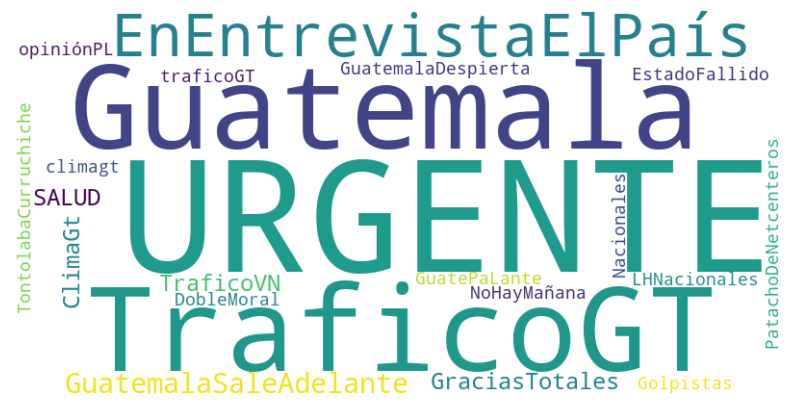

In [5]:
# Asegurarse de que los nombres de usuario estén en minúsculas tanto en 'interaction_df' como en 'df'
df['username_lower'] = df['user'].apply(lambda x: x['username'].lower() if isinstance(x, dict) and 'username' in x else None)

# Mostrar los usuarios con más respuestas
replied_users_counts = interaction_df[interaction_df['type'] == 'reply']['target'].value_counts().head(10)
print("Usuarios con más respuestas:")
print(replied_users_counts)

# Filtrar los tweets donde los usuarios más respondidos aparecen
top_replied_users = replied_users_counts.index.tolist()

# Asegurarnos de que los nombres de usuario en 'top_replied_users' también estén en minúsculas
top_replied_users = [user.lower() for user in top_replied_users]

# Filtrar los tweets donde estos usuarios son mencionados o participan
tweets_with_top_replied_users = df[df['username_lower'].isin(top_replied_users)]

# Verificar si se encontraron tweets
print("Número de tweets con usuarios que generan respuestas:", len(tweets_with_top_replied_users))

# Función para extraer hashtags de 'rawContent'
def extract_hashtags_from_text(text):
    return re.findall(r"#(\w+)", text)

# Extraer los hashtags del campo 'rawContent' de estos tweets
hashtags_in_top_replied_tweets = []
for text in tweets_with_top_replied_users['rawContent'].dropna():
    hashtags_in_top_replied_tweets.extend(extract_hashtags_from_text(text))

# Contar los hashtags más comunes
hashtag_counts_top_replied = Counter(hashtags_in_top_replied_tweets)

# Verificar si hay hashtags en estos tweets
if len(hashtag_counts_top_replied) == 0:
    print("No se encontraron hashtags en los tweets de los usuarios que generan más respuestas.")
else:
    # Mostrar los hashtags más comunes
    top_hashtags_replied_users = hashtag_counts_top_replied.most_common(10)
    print("Hashtags más discutidos por los usuarios que generan más respuestas:")
    for hashtag, count in top_hashtags_replied_users:
        print(f"{hashtag}: {count}")
    
    # Crear una nube de palabras para visualizar los hashtags más discutidos
    wordcloud_replied_users = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hashtag_counts_top_replied)

    # Visualizar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_replied_users, interpolation='bilinear')
    plt.axis('off')
    plt.show()


#URGENTE: Este es el hashtag más destacado, con 12 menciones, lo que indica que los tweets que generan más respuestas están relacionados con noticias o situaciones que se perciben como urgentes o críticas. Esto podría estar asociado a eventos importantes o crisis en el país.

#TraficoGT y #TraficoVN: Estos hashtags, con 6 y 2 menciones respectivamente, sugieren que el tráfico y la movilidad son temas recurrentes en las discusiones, probablemente relacionados con el tránsito en la Ciudad de Guatemala y otras áreas urbanas importantes.

#Guatemala y #GuatemalaSaleAdelante: Con un total de 6 y 3 menciones, respectivamente, estos hashtags revelan un enfoque en temas patrióticos y de orgullo nacional, con usuarios discutiendo sobre el futuro y los retos del país.

#EnEntrevistaElPaís: Este hashtag con 4 menciones sugiere que las entrevistas y conversaciones en medios internacionales también están generando respuestas en la audiencia.

#SALUD y #ClimaGt: Con 2 menciones cada uno, estos hashtags muestran que temas como la salud pública y el clima también están presentes en las discusiones.

#GraciasTotales: Utilizado en 2 ocasiones, este hashtag puede reflejar agradecimientos o mensajes de cierre en los tweets, lo que indica que algunas interacciones pueden estar relacionadas con agradecimientos públicos o reconocimientos.

Conclusión:
Los usuarios que generan más respuestas están discutiendo temas críticos como noticias urgentes, el tráfico y la movilidad en el país, y temas nacionales de interés como la salud, el clima y el futuro de Guatemala. Esto muestra que las discusiones que generan más interacción están relacionadas con problemas de impacto inmediato y relevancia pública.

### ¿Existe una correlación entre los usuarios más mencionados y los que generan más respuestas?

Usuarios que son tanto mencionados como reciben respuestas:
{'fjimenezmingob', 'ubaldomacu', 'guatemalagob', '__vadertg', 'barevalodeleon'}


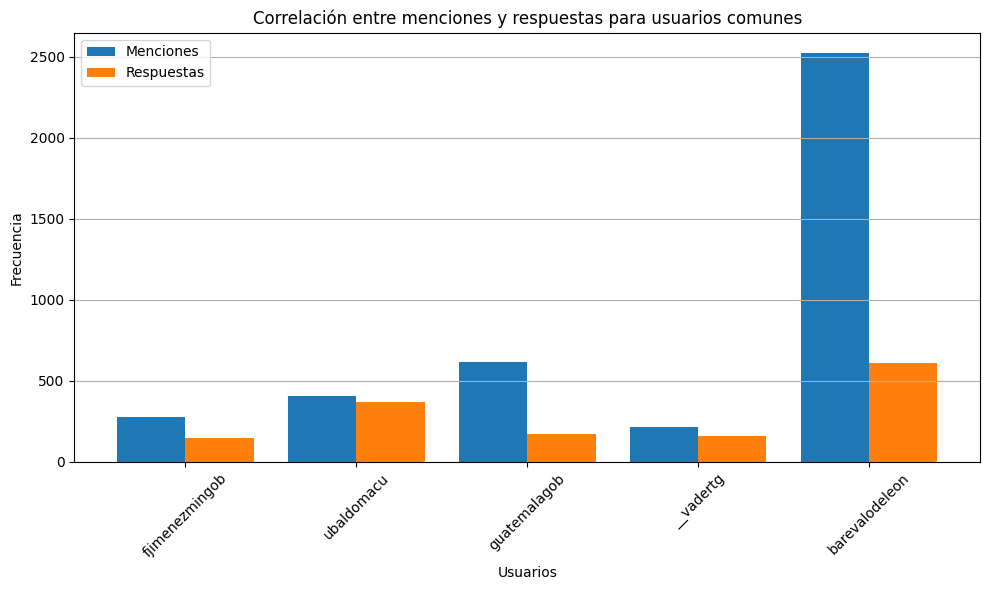

In [6]:
# Usuarios con más respuestas
replied_users_counts = interaction_df[interaction_df['type'] == 'reply']['target'].value_counts().head(10)

# Comparar las listas para encontrar usuarios que están en ambas
common_users = set(mention_counts.index).intersection(set(replied_users_counts.index))
print("Usuarios que son tanto mencionados como reciben respuestas:")
print(common_users)

common_users_list = list(common_users)

# Crear un DataFrame para los usuarios comunes
common_users_df = pd.DataFrame({
    'Menciones': mention_counts[common_users_list],
    'Respuestas': replied_users_counts[common_users_list]
})
# Crear gráfico de barras para visualizar la correlación
common_users_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Correlación entre menciones y respuestas para usuarios comunes')
plt.xlabel('Usuarios')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Mostrar gráfico
plt.tight_layout()
plt.show()


El gráfico sugiere que ciertos usuarios actúan como centros de atención con muchas menciones pero relativamente pocas respuestas, mientras que otros generan más interacción directa. Esto puede reflejar la naturaleza de las conversaciones o el rol que juegan estos usuarios en las discusiones públicas. En general, existe una correlación, aunque no necesariamente lineal, entre las menciones y las respuestas que generan.

### Task 5

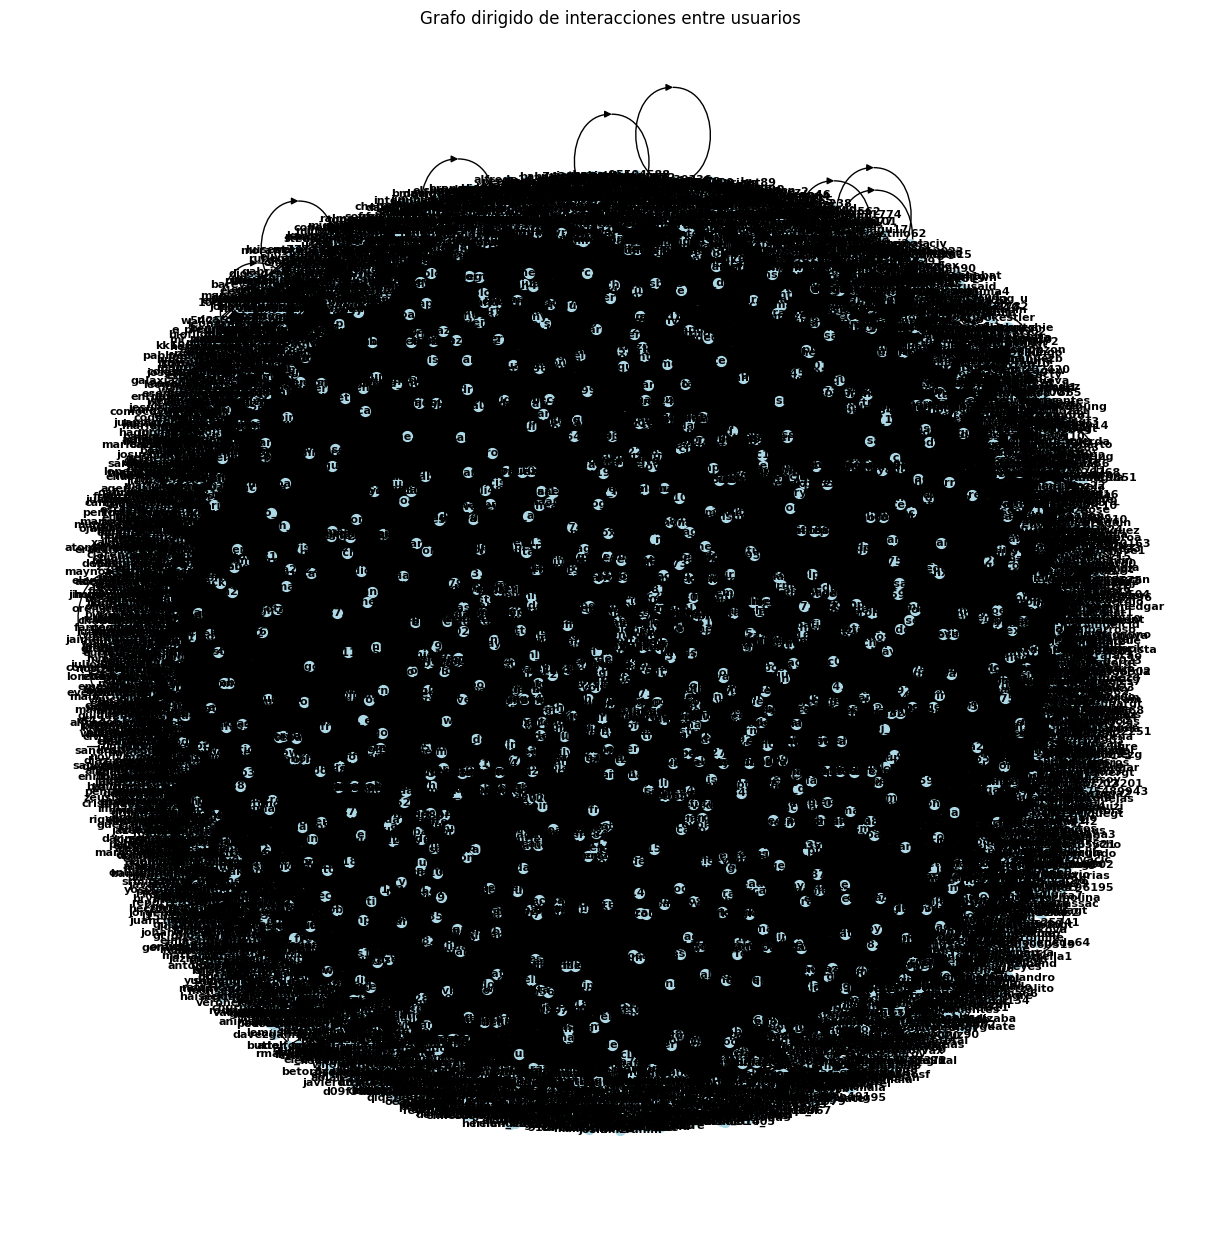

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Filtrar interacciones relevantes (menciones, respuestas, retweets)
interaction_types = ['mention', 'reply', 'retweet']
filtered_interactions = interaction_df[interaction_df['type'].isin(interaction_types)]

# Crear el grafo dirigido
G = nx.DiGraph()

# Añadir las interacciones filtradas al grafo
for index, row in filtered_interactions.iterrows():
    G.add_edge(row['source'], row['target'], interaction_type=row['type'])

# Visualización del grafo con NetworkX
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # Posiciones para los nodos
nx.draw(G, pos, with_labels=True, node_size=50, node_color='lightblue', font_size=8, font_weight='bold', arrows=True)
plt.title("Grafo dirigido de interacciones entre usuarios")
plt.show()


In [8]:
# Calcular la densidad de la red
density = nx.density(G)
print(f"Densidad de la red: {density:.4f}")
# Calcular el diámetro de la red
if nx.is_connected(G.to_undirected()):
    diameter = nx.diameter(G.to_undirected())
    print(f"Diámetro de la red: {diameter}")
else:
    print("La red no es completamente conectada, por lo que no se puede calcular el diámetro.")
# Calcular el coeficiente de agrupamiento
clustering_coefficient = nx.average_clustering(G.to_undirected())
print(f"Coeficiente de agrupamiento promedio: {clustering_coefficient:.4f}")


Densidad de la red: 0.0013
La red no es completamente conectada, por lo que no se puede calcular el diámetro.
Coeficiente de agrupamiento promedio: 0.3730



Los resultados del análisis de la topología de la red muestran una densidad de la red de 0.0013, lo que indica que las conexiones entre los usuarios son muy escasas en relación con el número máximo posible de enlaces. Esto sugiere que la mayoría de los usuarios no están directamente conectados entre sí, reflejando una red dispersa. Además, dado que la red no es completamente conectada, no fue posible calcular el diámetro de la red, lo que refuerza la idea de que hay subgrupos aislados dentro de la red. Por otro lado, el coeficiente de agrupamiento promedio es de 0.3730, lo que significa que, aunque la red es dispersa, existen ciertos grupos de usuarios que tienden a formar clústeres o comunidades con conexiones más densas entre sí, lo cual es característico de redes sociales donde los usuarios forman comunidades alrededor de temas o intereses comunes.

### Task 6

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


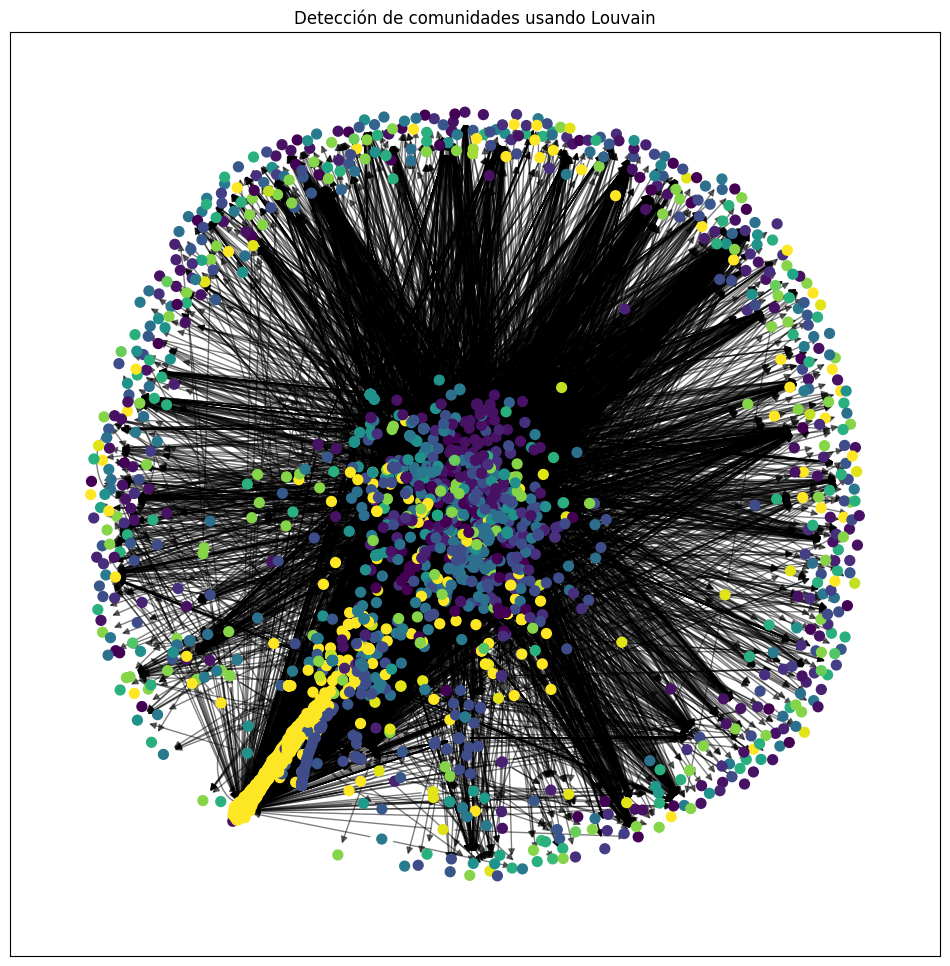

In [9]:
# Aplicación de algoritmos de detección de comunidades
%pip install python-louvain
import community as community_louvain
import networkx as nx
import matplotlib.pyplot as plt

# Detectar comunidades usando el algoritmo de Louvain
partition = community_louvain.best_partition(G.to_undirected())  # Convertimos el grafo a no dirigido

# Agregar la información de la comunidad a cada nodo
nx.set_node_attributes(G, partition, 'community')

# Visualización del grafo con las comunidades
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)

# Dibujar nodos, asignando colores según la comunidad
cmap = plt.get_cmap('viridis')
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=50, cmap=cmap, 
                       node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Detección de comunidades usando Louvain")
plt.show()


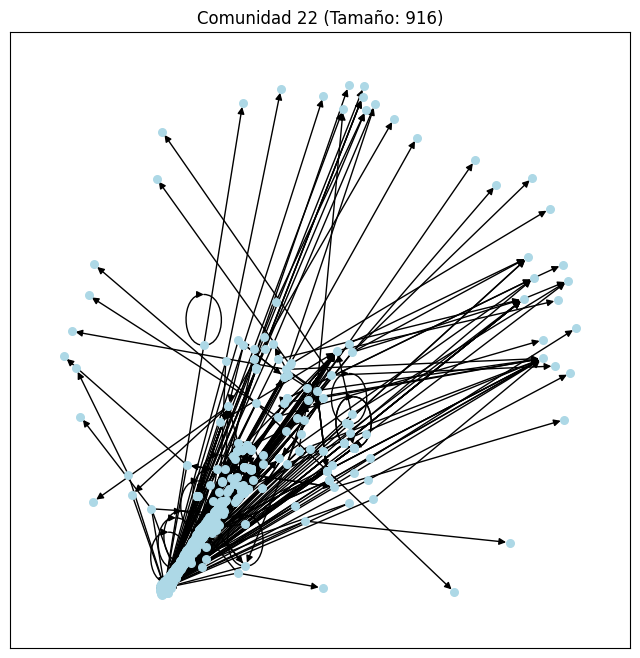

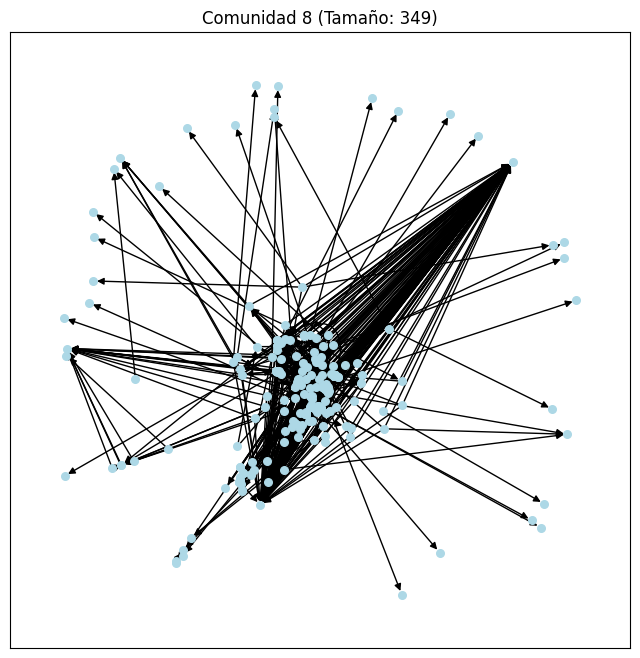

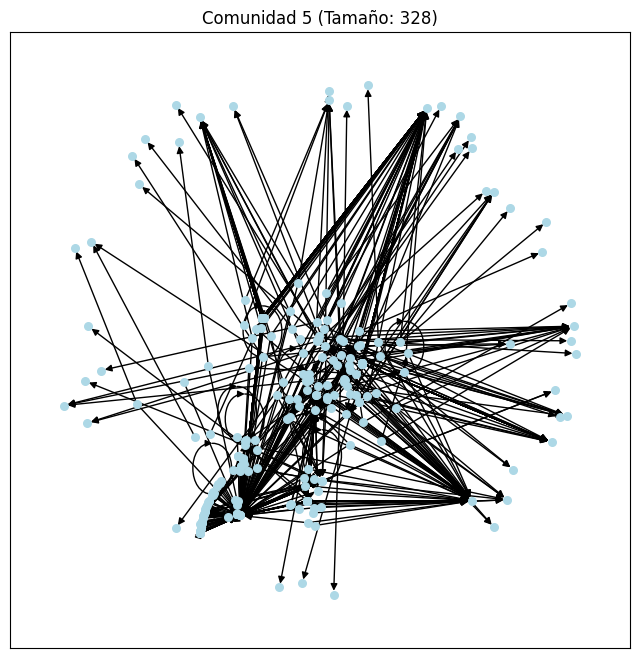

Comunidad 22: 916 nodos
Comunidad 8: 349 nodos
Comunidad 5: 328 nodos


In [10]:
# Visualización y caracterizacion de comunidades
# Obtener las comunidades y sus tamaños
from collections import Counter

community_sizes = Counter(partition.values())
largest_communities = community_sizes.most_common(3)  # Las 3 comunidades más grandes

# Filtrar nodos por cada comunidad
for community_id, size in largest_communities:
    nodes_in_community = [node for node, community in partition.items() if community == community_id]

    plt.figure(figsize=(8, 8))
    nx.draw_networkx(G.subgraph(nodes_in_community), pos, with_labels=False, node_size=30, node_color='lightblue')
    plt.title(f'Comunidad {community_id} (Tamaño: {size})')
    plt.show()

# Mostrar tamaños de las comunidades
for community_id, size in largest_communities:
    print(f"Comunidad {community_id}: {size} nodos")
